# Idea 4: Samples fitering - online

## Περιγραφή του αλγορίθμου
- Γίνεται εκπαίδευση με grokfast - EMA. Όταν **appl_sampl_filter** is False έχω μόνο αυτό, ενώ για True εφαρμόζω επιπλέον και την ιδέα 4 για πιο έξυπνη επιλογή δειγμάτων.
- Ο Dataloader έχει έναν custom sampler (WeightedRandomSampler) ο οποίος κάθε φορά διαλέγει ένα δείγμα με βάση κάποιο βάρος/πιθανότητα.
- Στην αρχή τα βάρη είναι όλα ίδια (ομοιόμορφη κατανομή) οπότε ο Dataloader λειτουργεί όπως συνήθως διαλέγοντας τυχαία ένα sample.
- Σε κάθε επανάληψη φτιάχνεται ένα ranking των δειγμάτων (με βάση του πόσο high frequency περιέχει το καθένα) το οποίο χρησιμοποιείται για να αποφασιστεί τι βάρος/πιθανότητα θα δοθεί σε κάθε δείγμα να επιλεγεί για εκπαίδευση. Το διάνυσμα βαρών/πιθανοτήτων ανανεώνεται κάθε **sampling_distr_upd_freq** επαναλήψεις.
- Στην κατασκευή του διανύσματος βαρών από την συνολική πιθανότητα 1 δίνουμε στα **top_k** δείγματα συνολικά **top_k_sampling_prob** (και στα υπόλοιπα length(dataset) - **top_k** δείγματα δίνουμε συνολικά το υπόλοιπο 1 - **top_k_sampling_prob**).
- Με **high_freq_better** is True ακολουθούμε την αρχική μας υπόθεση ότι τα δείγματα με high frequency είναι αυτά που θα πρέπει να ταΐσουμε το δίκτυο περισσότερο για να μάθει γρηγορότερα, για False γίνεται το αντίθετο.

## Οδηγίες χρήσης για τρέξιμο
Πήγαινε στον τίτλο **Execute training (by running main funciton)**. Πήγαινε στο parser.parse_args και όρισε τις τιμές που θες να δοκιμάσεις για grid search. Οι υπερπαράμετροι που σχετίζονται με την ιδέα 4 online είναι:

- **top_k**
- **top_k_sampling_prob**
- **high_freq_better**
- **sampling_distr_upd_freq**: Μάλλον είναι οκ στο 1 γιατί ακόμα και έτσι η εκπαίδευση δεν είναι αργή οπότε δεν έχω λόγο να το αυξήσω.

Αν κάποιος θέλει να τρέξει κάποιες τιμές για το grid search, έχω βάλει στον φάκελο και ένα αρχείο για να σημειώνουμε τις τιμές των υπερπαραμέτρων που δοκίμασε ο καθένας για να μην τρέχουμε όλοι τα ίδια. Βάλτε GPU P100 (νομίζω είναι ελαφρώς καλύτερη), εμένα για τα 100.000 βήματα που έχω βάλει να είναι το default ένα τρέξιμο που κάνω μόνο με grokfast (δηλαδή **appl_sampl_filter** is False) παίρνει περίπου **7 λεπτά** οπότε καλά είμαστε από χρόνο.



In [2]:
import kagglehub

# Maybe this is needed if you want to import private datasets 
# kagglehub.login()


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# hojjatk_mnist_dataset_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

# The dataset was uploaded from me but I made it public so you too can probably load it with this line
# _ = kagglehub.dataset_download("konstantinosbarkas/mnist-dataset-processed-from-local")

# print("Data source import complete.")


Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import sys

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/MNIST_data_processed_from_local/train.pt
/kaggle/input/MNIST_data_processed_from_local/test.pt


In [5]:
# !pip install -r /kaggle/input/enter-data-dn-req/requirements.txt


In [6]:
# Install the Grokfast library
!wget https://raw.githubusercontent.com/ironjr/grokfast/main/grokfast.py

sys.path.append("/kaggle/working")


--2025-02-07 10:57:36--  https://raw.githubusercontent.com/ironjr/grokfast/main/grokfast.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1703 (1.7K) [text/plain]
Saving to: ‘grokfast.py’

grokfast.py         100%[===================>]   1.66K  --.-KB/s    in 0s      

2025-02-07 10:57:36 (23.9 MB/s) - ‘grokfast.py’ saved [1703/1703]



In [7]:
# import argparse
# import gzip
import math
import random
# import struct
import time
from argparse import ArgumentParser
# from collections import Counter, defaultdict, deque
from itertools import islice
# from pathlib import Path
# from typing import Dict, List, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
# import torchvision.transforms as transforms
from functorch import grad, vmap
from sklearn.model_selection import train_test_split
from torch.autograd import grad

# from torch.nn.utils.stateless import functional_call, # This is deprecated, use the next one instead
from torch.func import functional_call
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, Dataset
from tqdm.auto import tqdm

from grokfast import gradfilter_ema,gradfilter_ma


In [8]:
results_dir = "/kaggle/working/results/mnist_online"
os.makedirs(results_dir, exist_ok=True)
dataset_path = "/kaggle/input/MNIST_data_processed_from_local/"


In [9]:
optimizer_dict = {"AdamW": torch.optim.AdamW, "Adam": torch.optim.Adam, "SGD": torch.optim.SGD}

activation_dict = {"ReLU": nn.ReLU, "Tanh": nn.Tanh, "Sigmoid": nn.Sigmoid, "GELU": nn.GELU}

loss_function_dict = {"MSE": nn.MSELoss, "CrossEntropy": nn.CrossEntropyLoss}


In [10]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x


In [220]:
def custom_collate_fn_2(batch):
    """Custom collate function to handle extra fields in the dataset."""
    images, labels, _, _ = zip(*batch)  # Ignore the indices and extra_fields for loss computation
    images = torch.stack(images)  # Stack images into a single tensor
    labels = torch.tensor(labels)  # Convert labels to a tensor
    return images, labels



def compute_loss(network, dataset, loss_function, device, N=2000, batch_size=50):
    """Computes mean loss of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        #dataset_loader =DataLoader(dataset, batch_size=256, shuffle=False)
        dataset_loader =DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=custom_collate_fn_2)
        
        loss_fn = loss_function_dict[loss_function](reduction='sum')
        one_hots = torch.eye(10, 10).to(device)
        total = 0
        points = 0
        
        for x, labels in islice(dataset_loader, N // batch_size):
            y = network(x.to(device))
            if loss_function == 'CrossEntropy':
                total += loss_fn(y, labels.to(device)).item()
            elif loss_function == 'MSE':
                total += loss_fn(y, one_hots[labels]).item()
            points += len(labels)
        return total / points



def compute_accuracy(model, dataset, device, N=2000,batch_size=50):
    """Utility to compute accuracy on a given dataset."""
    correct = 0
    total = 0

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn_2)
    #loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    N = min(len(dataset), N)
    batch_size = min(batch_size, N)
    
    for x, y in loader:  # Unpack index and extra_fields as well
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            outputs = model(x)
            predictions = outputs.argmax(dim=1)
        correct += (predictions == y).sum().item()
        total += y.size(0)
        if N is not None and total >= N:
            break
    return correct / total

    

In [240]:
# Added extra fields to keep ema_gra and history
# In this implementation I use variance metric --> I don't also store deviation metric for memory efficiency
class MyMNIST(torch.utils.data.Dataset):
    def __init__(self, dataset,targets, transform=None):
        """
        Custom dataset to extend MNIST with extra fields.
        """
        
        self.data = dataset.data.float()
        self.targets = targets
        self.transform = transform

        # Initialize extra fields
        self.extra_fields = [
            {
                "ema_grad": 0.0,
                "num_updates": 0,
                "variance_metric": 0.0,
            }
            for _ in range(len(self.data))
        ]

    def __getitem__(self, index):
        """Returns a single data sample with extra fields."""
        img, target = self.data[index], self.targets[index]

        # Ensure image is in [0,1] range
        img = img / 255.0  # Normalize manually

        # Apply any other transformations
        if self.transform:
            img = self.transform(img)

        extra_field = self.extra_fields[index]
        return img, target, int(index), extra_field
        
    def __len__(self):
        return len(self.data)
    def update_fields(self, indices, grad_stats, ema_alpha=0.9):
        """
        Update the extra fields for specified dataset indices.
        """

        for idx, grad in zip(indices, grad_stats):
            # Update EMA
            sample_field = self.extra_fields[idx]

            current_ema = sample_field["ema_grad"]
            updated_ema = ema_alpha * current_ema + (1 - ema_alpha) * grad
            sample_field["ema_grad"] = updated_ema

            deviation = abs(grad - current_ema)

            num_updates = sample_field["num_updates"] + 1  # Increment the update count
            
            current_avg_deviation = sample_field["variance_metric"] ** 0.5
            new_avg_deviation = ((current_avg_deviation * (num_updates - 1)) + deviation) / num_updates

            sample_field["num_updates"] = num_updates

            # Variance estimate (for higher sensitivity to fast changes)
            sample_field["variance_metric"] = new_avg_deviation**2


In [70]:

def custom_collate_fn(batch):
    images, labels, indices, extra_fields = zip(*batch)
    images = torch.stack(images)  # Stack images into a single tensor
    labels = torch.tensor(labels)  # Convert labels to a tensor
    return images, labels, indices, extra_fields

In [14]:
# Needed for per sample gradient computations
def select_random_subset(tensor, percentage, seed=42):
    """
    Flatten the parameter dimensions for each batch sample, select a percentage of elements,
    and return a tensor with shape [batch_size, selected_elements].

    Args:
        tensor (torch.Tensor): The gradient tensor of shape [batch_size, *parameter_dims].
        percentage (float): The percentage of elements to select.
        seed (int): Random seed for reproducibility.

    Returns:
        torch.Tensor: A tensor of shape [batch_size, selected_elements].
    """
    batch_size, *param_dims = tensor.shape  # Extract batch and parameter dimensions
    total_params = torch.prod(torch.tensor(param_dims))  # Total parameters per sample
    subset_size = int(total_params * percentage)  # 20% of parameters

    # Set seed for reproducibility
    random.seed(seed)
    indices = random.sample(range(total_params), subset_size)  # Random indices for selection

    # Flatten parameter dimensions and select elements for each batch
    flat_tensor = tensor.view(batch_size, -1)  # Flatten parameter dimensions for each sample
    selected_subset = flat_tensor[:, indices]  # Select the same random indices across the batch

    return selected_subset


In [15]:
# Needed for online sample filtering
def rank_to_sampling_weights(my_dataset, top_k, top_k_sampling_prob, high_freq_better):
    """
    Rank samples by variance_metric and assign sampling weights.

    Parameters:
    - my_dataset: MyMNIST object.
    - top_k: Fraction of top samples to assign higher sampling probability.
    - top_k_sampling_prob: Probability assigned to the top_k fraction of samples.

    Returns:
    - new_weights: List of sampling weights for each sample.
    """
    # Calculate the number of top_k samples
    num_samples = len(my_dataset)
    top_k_count = int(top_k * num_samples)

    # Sort indices by variance_metric in descending order
    sorted_indices = sorted(
        range(num_samples),
        key=lambda idx: my_dataset.dataset.extra_fields[idx]["variance_metric"],
        reverse=high_freq_better,
    )

    # Initialize new_weights with zeros
    new_weights = [0.0] * num_samples

    # Assign weights to the top_k samples
    for idx in sorted_indices[:top_k_count]:
        new_weights[idx] = top_k_sampling_prob / top_k_count

    # Assign weights to the rest of the samples
    for idx in sorted_indices[top_k_count:]:
        new_weights[idx] = (1 - top_k_sampling_prob) / (num_samples - top_k_count)

    return new_weights


## def main

In [246]:
import random
from functorch import vmap, grad
from torch.nn.utils.stateless import functional_call

def main(args):
    log_freq = math.ceil(args.optimization_steps / 150)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = torch.float32

    torch.set_default_dtype(dtype)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    random.seed(args.seed)
    np.random.seed(args.seed)

     # load dataset
    transform = transforms.ToTensor()

    train_dataset = torchvision.datasets.MNIST(root=args.download_directory, train=True,
        transform=torchvision.transforms.ToTensor(), download=True)
    

    test = torchvision.datasets.MNIST(root=args.download_directory, train=False,
        transform=torchvision.transforms.ToTensor(), download=True)

    # Create indices stratified by digit labels
    # train_indices = list(range(len(train_dataset)))
    # train_labels = [train_dataset.targets[i].item() for i in train_indices]

    transform = None

    train_dataset = MyMNIST(train_dataset,train_dataset.targets,transform=transform)
    test = MyMNIST(test,test.targets, transform=transform)


    # # Use train_test_split with stratification to randomly select a specified number of samples (args.train_points)
    # stratified_indices, _ = train_test_split(
    #     train_indices,
    #     train_size=args.train_points,
    #     stratify=train_labels,
    #     random_state=args.seed
    # )

    # Create a subset with the stratified indices
    train_subset = torch.utils.data.Subset(train_dataset, range(args.train_points))

    
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=args.batch_size, shuffle=True,collate_fn=custom_collate_fn_2)

    # Create initial weights for uniform sampling
    weights = [1.0] * len(train_subset)
    sampler = WeightedRandomSampler(weights, len(weights))

    train_loader = DataLoader(train_subset, batch_size=args.batch_size, sampler=sampler, collate_fn=custom_collate_fn)

    
    activation_fn = activation_dict[args.activation]

    #                                   Create model
    #   -------------------------------------------------------------------------------   #

    layers = [nn.Flatten()]
    for i in range(args.depth):
        if i == 0:
            layers.append(nn.Linear(784, args.width))
            layers.append(activation_fn())
        elif i == args.depth - 1:
            layers.append(nn.Linear(args.width, 10))
        else:
            layers.append(nn.Linear(args.width, args.width))
            layers.append(activation_fn())
    mlp = nn.Sequential(*layers).to(device)
    with torch.no_grad():
        for p in mlp.parameters():
            p.data = args.initialization_scale * p.data
    nparams = sum([p.numel() for p in mlp.parameters() if p.requires_grad])
    print(f"Number of parameters: {nparams}")

    # create optimizer
    assert args.optimizer in optimizer_dict, f"Unsupported optimizer choice: {args.optimizer}"
    optimizer = optimizer_dict[args.optimizer](mlp.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # define loss function
    assert args.loss_function in loss_function_dict
    loss_fn = loss_function_dict[args.loss_function]()

    # Needed for per sample gradient computations
    if args.appl_sampl_filter:
        # Define a function for forward + loss computation
        def compute_loss_vmap(params, buffers, model, x, y):
            # Use functional_call to pass parameters and buffers explicitly
            logits = functional_call(model, {**params, **buffers}, x.unsqueeze(0))  # Single input
            loss = loss_fn(logits, y.unsqueeze(0))  # Single output
            return loss.mean()
    
        # Prepare model parameters and buffers
        params_and_buffers = {**dict(mlp.named_parameters()), **dict(mlp.named_buffers())}
    
        params = {k: v for k, v in params_and_buffers.items() if v.requires_grad}
        buffers = {k: v for k, v in params_and_buffers.items() if not v.requires_grad}


        # Create the gradient function
        gradient_fn = grad(compute_loss_vmap)
    
        # Initialize EMA and metric history for each sample
        gradient_ema = [0.0 for _ in range(len(train_subset))]
        # gradient_metric_history = [[] for _ in range(len(train_subset))] # Probably unused

    #                           Start Training below
    #   -------------------------------------------------------------------------------   #
    log_steps, train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], [], []
    one_hots = torch.eye(10, 10).to(device)

    grads = None
    
    
    with tqdm(total=args.optimization_steps, dynamic_ncols=True) as pbar:

        reached_early_stop = False  # Flag to indicate early stopping
        steps_to_reach_val_acc = None  # Variable to store steps for 0.95 validation accuracy

        stable_threshold = 1000  # Number of steps the validation accuracy must remain > 0.9
        stable_steps = 0  # Counter for steps validation accuracy remains above 0.9
        
        data_iter = cycle(train_loader)
        
        for step in range(args.optimization_steps):
            if reached_early_stop: break
            # Update the sampling distribution (according to the latest ranking of the samples)
            if args.appl_sampl_filter and step % args.sampling_distr_upd_freq == 0 and step >= 200:
                # Rebuild the train_loader with new sampling weights, for example
                weights = rank_to_sampling_weights(train_subset, args.top_k, args.top_k_sampling_prob, args.high_freq_better)
                new_sampler = WeightedRandomSampler(weights, num_samples=len(weights))
                train_loader = DataLoader(
                    train_subset,
                    batch_size=args.batch_size,
                    sampler=new_sampler,  # WeightedRandomSampler or anything you want
                    collate_fn=custom_collate_fn
                )
                # Re-initialize the iterator to the new train_loader
                data_iter = cycle(train_loader)

            x, labels, indices, _ = next(data_iter)

            do_log = (step < 150 and step % 10 == 0) or step % log_freq == 0
            
            #do_log = (step < 30) or (step < 150 and step % 10 == 0) or step % log_freq == 0
            if do_log:
                with torch.no_grad():
                    train_losses.append(compute_loss(mlp, train_subset, args.loss_function, device, N=len(train_subset)))
                    train_accuracies.append(compute_accuracy(mlp, train_subset, device, N=len(train_subset)))
                    test_losses.append(compute_loss(mlp, test, args.loss_function, device, N=len(test)))
                    test_accuracies.append(compute_accuracy(mlp, test, device, N=len(test)))
                    log_steps.append(step)
                    pbar.set_description(
                        "Loss: {0:1.1e}|{1:1.1e}. Acc: {2:2.1f}%|{3:2.1f}%".format(
                            train_losses[-1],
                            test_losses[-1],
                            train_accuracies[-1] * 100,
                            test_accuracies[-1] * 100,
                        )
                    )


            x, labels = x.to(device), labels.to(device)
            y = mlp(x.to(device))
            if args.loss_function == "CrossEntropy":
                # Use integer labels for CrossEntropyLoss
                loss = loss_fn(y, labels.to(device))
            elif args.loss_function == "MSE":
                loss = loss_fn(y, one_hots[labels])

            optimizer.zero_grad()
            
            loss.backward() # Do I need create_graph?
            #loss.backward(create_graph=True)

            if args.appl_sampl_filter:  # Unnecessary if we are not applying sample filtering
                # -----------------------------------------------------------------
                #   Gradient Stats: Capture grads for each sample
                # -----------------------------------------------------------------
                # Identify the last two Linear layers dynamically
                batch_gradients = []

                with torch.no_grad():
                    per_sample_grads = vmap(gradient_fn, in_dims=(None, None, None, 0, 0))(
                        params, buffers, mlp, x, labels
                    )
                
                    # Extract gradients for the target layers
                    last_layer_grad = per_sample_grads["3.weight"]  # Adjust key as needed
                    second_last_layer_grad = per_sample_grads["5.weight"]
                
                    # Select a subset of gradients
                    percentage_s_l = 0.2
                    percentage_l = 0.2
                    selected_last = select_random_subset(last_layer_grad, percentage_l, seed=42)
                    selected_second_last = select_random_subset(second_last_layer_grad, percentage_s_l, seed=42)
                
                    # Compute the average and detach
                    selected_last_avg = selected_last.mean(dim=-1).detach().cpu()
                    selected_second_last_avg = selected_second_last.mean(dim=-1).detach().cpu()
                    total_avg = (selected_last_avg + selected_second_last_avg) / 2

                train_subset.dataset.update_fields(indices, total_avg, args.ema_alpha_sampl_rank)

            # -----------------------------------------------------------------
            # -----------------------------------------------------------------

            # Grokfast (EMA)
            # Add required code for applying grokfast

            if args.filter == "none":
                pass
            elif args.filter == "ma":
                grads = gradfilter_ma(mlp, grads=grads, window_size=args.window_size, lamb=args.lamb)
            elif args.filter == "ema":
                grads = gradfilter_ema(mlp, grads=grads, alpha=args.alpha, lamb=args.lamb)
            else:
                raise ValueError(f"Invalid gradient filter type `{args.filter}`")
        
            optimizer.step()

            test_acc = test_accuracies[-1] if len(test_accuracies) > 0 else 0

            if test_acc >= 0.9 and steps_to_reach_val_acc is None:
                steps_to_reach_val_acc = step

            #Check for early stopping conditions
            if test_acc > 0.85:
                stable_steps += 1
            else:
                stable_steps = 0  # Reset counter if accuracy drops below 0.85

            if stable_steps >= stable_threshold and test_acc >= 0.9:
                reached_early_stop = True
                print(f"Validation accuracy of 0.9 reached and remained > 0.85 for {stable_threshold} step at step {step}")

            
            pbar.update(1)
                

    # Save results
    specific_result_dir = f"mnist_{args.label}.pt"
    results_filename = os.path.join(results_dir, specific_result_dir)
    torch.save(
        {
            "its": log_steps,
            "train_acc": train_accuracies,
            "train_loss": train_losses,
            "val_acc": test_accuracies,
            "val_loss": test_losses,
            "steps_to_reach": steps_to_reach_val_acc,
            "model_state_dict": mlp.state_dict(),  # Save the model's state dictionary, maybe unnecessary
        },
        results_filename,
    )

    print(f"\nSteps needed to reach 0.9 validation accuracy: {steps_to_reach_val_acc}")


In [209]:
# Remove the extra arguments passed by the Jupyter Notebook kernel
sys.argv = [""]


In [254]:
# Functions for creating plot
import os
import torch
import matplotlib.pyplot as plt

def analyze_results(label, results_dir="/kaggle/working/results/mnist_online"):
    """
    Loads model results, extracts accuracy/loss data, and generates plots.
    
    Args:
        label (str): Label identifier for the results file.
        results_dir (str): Directory where results are stored.
    
    Returns:
        None
    """

    # Define file paths
    filename = f"mnist_{label}.pt"
    results_filename = os.path.join(results_dir, filename)

    filename_plot_acc = f"mnist_{label}_acc.png"
    results_filename_plot_acc = os.path.join(results_dir, filename_plot_acc)

    filename_plot_loss = f"mnist_{label}_loss.png"
    results_filename_plot_loss = os.path.join(results_dir, filename_plot_loss)

    try:
        # Load results
        results = torch.load(results_filename, weights_only=True)

        # Extract data
        its = results["its"]  # Optimization steps
        train_acc = results["train_acc"]  # Training accuracy
        val_acc = results["val_acc"]  # Validation accuracy
        train_loss = results["train_loss"]  # Training loss
        val_loss = results["val_loss"]  # Validation loss
        steps_to_reach = results["steps_to_reach"]  # Steps to reach 90% validation accuracy

        print(f"Steps needed to reach 0.9 validation accuracy: {steps_to_reach}")

        # Plot Accuracy
        plt.figure()
        plt.plot(its, train_acc, label="Train Accuracy")
        plt.plot(its, val_acc, label="Validation Accuracy")

        # Find and annotate the maximum validation accuracy
        max_val_acc = max(val_acc)
        max_val_idx = val_acc.index(max_val_acc)
        plt.annotate(f"Max Val Acc: {max_val_acc:.4f}", 
                     (its[max_val_idx], max_val_acc), 
                     textcoords="offset points", 
                     xytext=(0, 10), 
                     ha='center', 
                     fontsize=10, 
                     color='red')

        plt.legend()
        plt.title(f"Accuracy - Grokfast:{args.filter} Sample Filtering:{args.appl_sampl_filter}")
        plt.xlabel("Optimization Steps")
        plt.ylabel("Accuracy")
        plt.xscale("log", base=10)
        plt.grid()
        plt.figtext(0.5, -0.1, f"Steps to reach val=0.9 = {steps_to_reach}", 
            ha="center", fontsize=10, style="italic")
       # plt.savefig(results_filename_plot_acc, dpi=150)
        plt.show()
        plt.close()

        print("Plots saved successfully.")

    except FileNotFoundError:
        print(f"Error: Results file {results_filename} not found.")
    except Exception as e:
        print(f"Error while processing {label}: {e}")

def plot_all_experiments_together(labels, results_dir="/kaggle/working/results/mnist_online", show_only_val=False):
    """
    Plots train and validation accuracy for multiple experiments in a single graph.
    Allows showing only validation accuracy if `show_only_val=True`.

    Args:
        labels (list of str): List of labels corresponding to result files.
        results_dir (str): Directory where results are stored.
        show_only_val (bool): If True, only plots validation accuracy.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))  # Set figure size

    # Generate distinct colors for each experiment
    base_colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))  

    for i, label in enumerate(labels):
        results_filename = os.path.join(results_dir, f"mnist_{label}.pt")

        try:
            # Load results
            results = torch.load(results_filename, weights_only=True)
            its = results["its"]
            train_acc = results["train_acc"]
            val_acc = results["val_acc"]

            # Assign colors for train and validation curves
            val_color = base_colors[i]  # Primary color for validation
            train_color = tuple(c * 0.7 for c in base_colors[i])  # Slightly darker shade for train
            steps_to_reach = results["steps_to_reach"]
            
            # Plot validation accuracy (always shown)
            plt.plot(its, val_acc, label=f"Validation ({label})", color=val_color, linestyle="solid")
            plt.figtext(0.5, -0.1, f"Steps to reach val=0.9 = {steps_to_reach}", 
                ha="center", fontsize=10, style="italic")
        
            # Plot train accuracy if `show_only_val` is False
            if not show_only_val:
                plt.plot(its, train_acc, label=f"Train ({label})", color=train_color, linestyle="dashed")

        except FileNotFoundError:
            print(f"Warning: Results file {results_filename} not found.")
        except Exception as e:
            print(f"Error while processing {label}: {e}")

    plt.legend()
    plt.title("Train & Validation Accuracy for Multiple Experiments" if not show_only_val else "Validation Accuracy for Multiple Experiments")
    plt.xlabel("Optimization Steps")
    plt.ylabel("Accuracy")
    plt.xscale("log", base=10)
    plt.grid()
    
    # Save and show the plot
    filename = "combined_train_val_plot.png" if not show_only_val else "combined_val_plot.png"
    plot_path = os.path.join(results_dir, filename)
    #plt.savefig(plot_path, dpi=150)
    plt.show()

## Execute training (by running main function)

From now on i just train networks with different configurations every timeand then I print their results after.

Below is Benchmark:

    * no grokfast applied
    * no filtering
    * wd = 0.01


            

In [217]:
if __name__ == "__main__":
    # Same as used in paper of Grokfast
    parser = ArgumentParser(description="Train a model on MNIST without custom sampling")
    
    parser.add_argument("--label", type=str, default="")
    parser.add_argument("--seed", type=int, default=0)
    
    parser.add_argument("--train_points", type=int, default=1000)
    parser.add_argument("--optimization_steps", type=int, default=100000)
    parser.add_argument("--batch_size", type=int, default=200)
    parser.add_argument("--loss_function", type=str, default="MSE") #MSE or CrossEntropy
    parser.add_argument("--optimizer", type=str, default="AdamW")
    parser.add_argument("--weight_decay", type=float, default=0.01)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--initialization_scale", type=float, default=8.0)
    parser.add_argument("--download_directory", type=str, default=".")
    parser.add_argument("--depth", type=int, default=3)
    parser.add_argument("--width", type=int, default=200)
    parser.add_argument("--activation", type=str, default="ReLU")

    # Grokfast
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.8)
    parser.add_argument("--lamb", type=float, default=0.1)

    # Samples ranking
    parser.add_argument("--ema_alpha_sampl_rank", type=float, default=0.9)

    # Boolean arguements need this due to bad behavior of parser.parse_args
    def boolean_string(s):
        if s not in {"False", "True"}:
            raise ValueError("Not a valid boolean string")
        return s == "True"

    # These are the hyperparameters related to our online sampling filtering algorithm
    parser.add_argument("--appl_sampl_filter", type=boolean_string, default=True)  # If False, perform regular training
    parser.add_argument("--sampling_distr_upd_freq", type=int, default=1)  # How often to update the sampling distribution
    parser.add_argument("--top_k", type=float, default=0.1)  # Fraction of samples to select more frequently
    parser.add_argument("--top_k_sampling_prob", type=float, default=0.9)  # Probability of selecting a sample from the top-k
    parser.add_argument("--high_freq_better", type=boolean_string, default=True)  # If True, samples with higher frequency gradient content are considered better for training

    # -----------------------------------------------------------------
    # Try different hyperparameter values for your grid search here
    # -----------------------------------------------------------------
    args = parser.parse_args(
        [
            "--appl_sampl_filter", "False", # booleans as non strings in order to work
            "--sampling_distr_upd_freq", "1", # the rest as strings for some reason
            "--top_k", "0.1",
            "--top_k_sampling_prob", "0.9",
            "--high_freq_better", "True",
        ]
    )
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    # Create arg.label for the filename of the saved results
    if not args.appl_sampl_filter:
        args.label = f"filter{args.filter}_sampling_{args.appl_sampl_filter}"
    else:
        args.label = f"high_freq_{args.high_freq_better}_top_k_{args.top_k}_top_k_prob_{args.top_k_sampling_prob}_upd_freq_{args.sampling_distr_upd_freq}"

    # Training with time recording

    # Start the timer
    start_time = time.time()

    # Call your training function
    main(args)

    # End the timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to minutes and seconds (optional)
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Training completed in {int(minutes)} minutes and {int(seconds)} seconds.")
    print(f"label:{args.label}")

Number of parameters: 199210


  0%|          | 0/100000 [00:00<?, ?it/s]


Steps needed to reach 0.9 validation accuracy: None
Training completed in 40 minutes and 58 seconds.
label:filternone_sampling_False


Steps needed to reach 0.9 validation accuracy: None


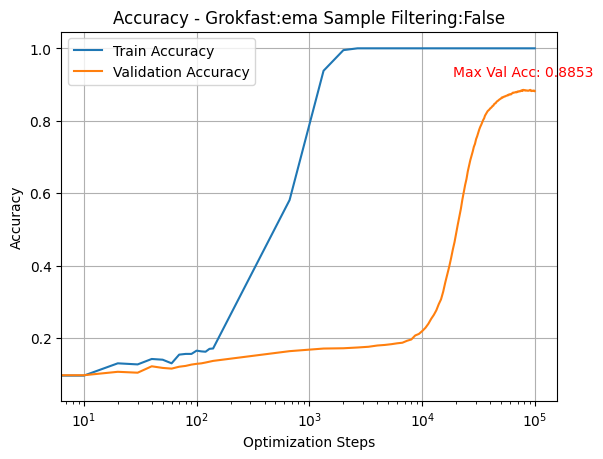

Plots saved successfully.


In [249]:
args.label="filternone_sampling_False"
analyze_results(args.label)

In [238]:
if __name__ == "__main__":
    # Same as used in paper of Grokfast
    parser = ArgumentParser(description="Train a model on MNIST without custom sampling")
    
    parser.add_argument("--label", type=str, default="")
    parser.add_argument("--seed", type=int, default=0)
    
    parser.add_argument("--train_points", type=int, default=1000)
    parser.add_argument("--optimization_steps", type=int, default=100000)
    parser.add_argument("--batch_size", type=int, default=200)
    parser.add_argument("--loss_function", type=str, default="MSE") #MSE or CrossEntropy
    parser.add_argument("--optimizer", type=str, default="AdamW")
    parser.add_argument("--weight_decay", type=float, default=2.0)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--initialization_scale", type=float, default=8.0)
    parser.add_argument("--download_directory", type=str, default=".")
    parser.add_argument("--depth", type=int, default=3)
    parser.add_argument("--width", type=int, default=200)
    parser.add_argument("--activation", type=str, default="ReLU")

    # Grokfast
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="ema")
    parser.add_argument("--alpha", type=float, default=0.8)
    parser.add_argument("--lamb", type=float, default=0.1)

    # Samples ranking
    parser.add_argument("--ema_alpha_sampl_rank", type=float, default=0.9)

    # Boolean arguements need this due to bad behavior of parser.parse_args
    def boolean_string(s):
        if s not in {"False", "True"}:
            raise ValueError("Not a valid boolean string")
        return s == "True"

    # These are the hyperparameters related to our online sampling filtering algorithm
    parser.add_argument("--appl_sampl_filter", type=boolean_string, default=True)  # If False, perform regular training
    parser.add_argument("--sampling_distr_upd_freq", type=int, default=1)  # How often to update the sampling distribution
    parser.add_argument("--top_k", type=float, default=0.1)  # Fraction of samples to select more frequently
    parser.add_argument("--top_k_sampling_prob", type=float, default=0.9)  # Probability of selecting a sample from the top-k
    parser.add_argument("--high_freq_better", type=boolean_string, default=True)  # If True, samples with higher frequency gradient content are considered better for training

    # -----------------------------------------------------------------
    # Try different hyperparameter values for your grid search here
    # -----------------------------------------------------------------
    args = parser.parse_args(
        [
            "--appl_sampl_filter", "False", # booleans as non strings in order to work
            "--sampling_distr_upd_freq", "1", # the rest as strings for some reason
            "--top_k", "0.1",
            "--top_k_sampling_prob", "0.9",
            "--high_freq_better", "True",
        ]
    )
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    # Create arg.label for the filename of the saved results
    if not args.appl_sampl_filter:
        args.label = f"filter{args.filter}_sampling_{args.appl_sampl_filter}"
    else:
        args.label = f"high_freq_{args.high_freq_better}_top_k_{args.top_k}_top_k_prob_{args.top_k_sampling_prob}_upd_freq_{args.sampling_distr_upd_freq}"

    # Training with time recording

    # Start the timer
    start_time = time.time()

    # Call your training function
    main(args)

    # End the timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to minutes and seconds (optional)
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Training completed in {int(minutes)} minutes and {int(seconds)} seconds.")
    print(f"label:{args.label}")

Number of parameters: 199210


  0%|          | 0/10000 [00:00<?, ?it/s]


Steps needed to reach 0.9 validation accuracy: None
Training completed in 2 minutes and 15 seconds.
label:filterema_sampling_False


Steps needed to reach 0.9 validation accuracy: 11339


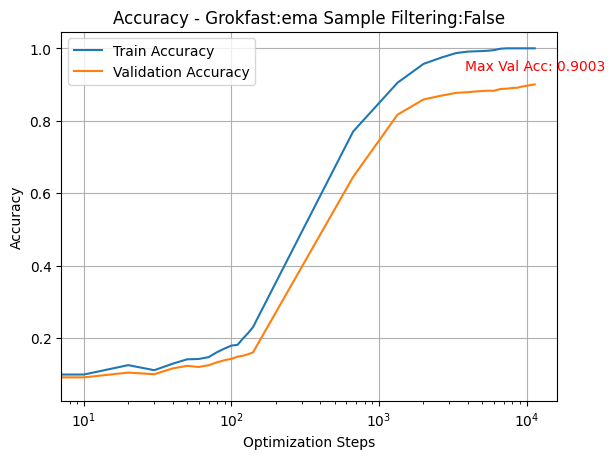

Plots saved successfully.


In [251]:
args.label="filterema_sampling_False"
analyze_results(args.label)

In [242]:
# Define possible values for each parameter
param_grid = {
    "top_k": [0.2],  # Convert to float
    "top_k_sampling_prob": [0.7],  # Convert to float
    "sampling_distr_upd_freq": [10],  # Convert to int
    "high_freq_better": [True]  # Boolean parameter
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))

# Run main in a loop for each combination
for param_values in param_combinations:
    # Extract parameter values
    top_k = param_values[0]
    top_k_sampling_prob = param_values[1]
    sampling_distr_upd_freq = param_values[2]
    high_freq_better = param_values[3]  # Boolean value
    
    # Ensure boolean values are correctly formatted as strings for argparse
    high_freq_better_str = "True" if high_freq_better else "False"

    # Create args dynamically
    args_list = [
        "--appl_sampl_filter" , "True",
        "--top_k", str(top_k),
        "--top_k_sampling_prob", str(top_k_sampling_prob),
        "--sampling_distr_upd_freq", str(sampling_distr_upd_freq),
        "--high_freq_better", high_freq_better_str,
        "--label", f"{top_k}_{top_k_sampling_prob}_{sampling_distr_upd_freq}_{high_freq_better}"
    ]

    # Debug print statement
    print(f"\nRunning with parameters: {args_list}")

    # Parse the arguments dynamically
    args = parser.parse_args(args_list)

    # Call main() with the updated args
    main(args)


Running with parameters: ['--appl_sampl_filter', 'True', '--top_k', '0.2', '--top_k_sampling_prob', '0.7', '--sampling_distr_upd_freq', '10', '--high_freq_better', 'True', '--label', '0.2_0.7_10_True']
Number of parameters: 199210


<ipython-input-234-38e1f7d08ec3>:105: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.grad` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.grad` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  gradient_fn = grad(compute_loss_vmap)


  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-234-38e1f7d08ec3>:185: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(gradient_fn, in_dims=(None, None, None, 0, 0))(
<ipython-input-234-38e1f7d08ec3>:93: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  logits = functional_call(model, {**params, **buffers}, x.unsqueeze(0))  # Single input



Steps needed to reach 0.9 validation accuracy: None


Steps needed to reach 0.9 validation accuracy: None


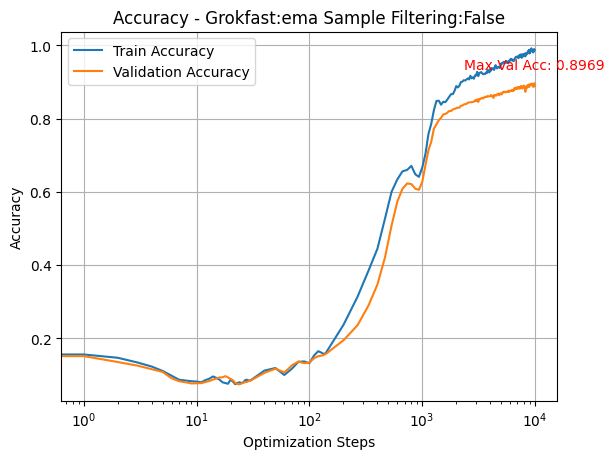

Plots saved successfully.


In [252]:
#/kaggle/working/results/mnist_online/mnist_high_freq_True_top_k_0.2_top_k_prob_0.9_upd_freq_1.pt
args.label="high_freq_True_top_k_0.2_top_k_prob_0.9_upd_freq_1"
analyze_results(args.label)

In [244]:
    args_list = [
        "--appl_sampl_filter" , "False",
    ]

    # Parse the arguments dynamically
    args = parser.parse_args(args_list)

    # Call main() with the updated args
    main(args)

Number of parameters: 199210


  0%|          | 0/10000 [00:00<?, ?it/s]


Steps needed to reach 0.9 validation accuracy: None


Steps needed to reach 0.9 validation accuracy: None


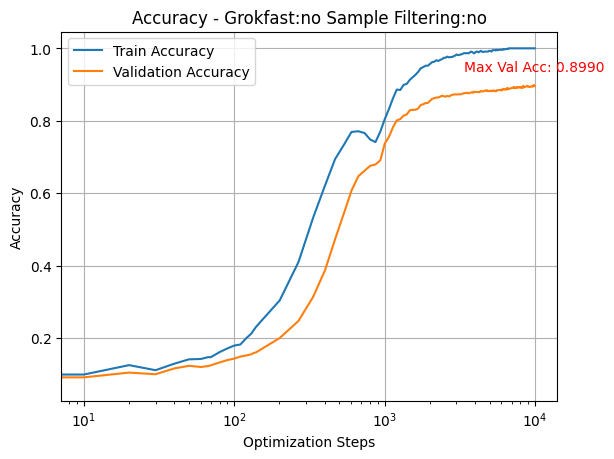

Plots saved successfully.


In [245]:
analyze_results(args.label)

In [214]:
if __name__ == "__main__":
    # Same as used in paper of Grokfast
    parser = ArgumentParser(description="Train a model on MNIST without custom sampling")
    
    parser.add_argument("--label", type=str, default="")
    parser.add_argument("--seed", type=int, default=0)
    
    parser.add_argument("--train_points", type=int, default=1000)
    parser.add_argument("--optimization_steps", type=int, default=10000)
    parser.add_argument("--batch_size", type=int, default=200)
    parser.add_argument("--loss_function", type=str, default="MSE") #MSE or CrossEntropy
    parser.add_argument("--optimizer", type=str, default="AdamW")
    parser.add_argument("--weight_decay", type=float, default=2.0)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--initialization_scale", type=float, default=8.0)
    parser.add_argument("--download_directory", type=str, default=".")
    parser.add_argument("--depth", type=int, default=3)
    parser.add_argument("--width", type=int, default=200)
    parser.add_argument("--activation", type=str, default="ReLU")

    # Grokfast
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.8)
    parser.add_argument("--lamb", type=float, default=0.1)

    # Samples ranking
    parser.add_argument("--ema_alpha_sampl_rank", type=float, default=0.9)

    # Boolean arguements need this due to bad behavior of parser.parse_args
    def boolean_string(s):
        if s not in {"False", "True"}:
            raise ValueError("Not a valid boolean string")
        return s == "True"

    # These are the hyperparameters related to our online sampling filtering algorithm
    parser.add_argument("--appl_sampl_filter", type=boolean_string, default=True)  # If False, perform regular training
    parser.add_argument("--sampling_distr_upd_freq", type=int, default=1)  # How often to update the sampling distribution
    parser.add_argument("--top_k", type=float, default=0.1)  # Fraction of samples to select more frequently
    parser.add_argument("--top_k_sampling_prob", type=float, default=0.9)  # Probability of selecting a sample from the top-k
    parser.add_argument("--high_freq_better", type=boolean_string, default=True)  # If True, samples with higher frequency gradient content are considered better for training

    # -----------------------------------------------------------------
    # Try different hyperparameter values for your grid search here
    # -----------------------------------------------------------------
    args = parser.parse_args(
        [
            "--appl_sampl_filter", "False", # booleans as non strings in order to work
            "--sampling_distr_upd_freq", "1", # the rest as strings for some reason
            "--top_k", "0.1",
            "--top_k_sampling_prob", "0.9",
            "--high_freq_better", "True",
        ]
    )
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    # Create arg.label for the filename of the saved results
    if not args.appl_sampl_filter:
        args.label = f"filter{args.filter}_sampling_{args.appl_sampl_filter}_v2"
    else:
        args.label = f"high_freq_{args.high_freq_better}_top_k_{args.top_k}_top_k_prob_{args.top_k_sampling_prob}_upd_freq_{args.sampling_distr_upd_freq}"

    # Training with time recording

    # Start the timer
    start_time = time.time()

    # Call your training function
    main(args)

    # End the timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to minutes and seconds (optional)
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Training completed in {int(minutes)} minutes and {int(seconds)} seconds.")
    print(f"label:{args.label}")

Number of parameters: 199210


  0%|          | 0/10000 [00:00<?, ?it/s]


Steps needed to reach 0.9 validation accuracy: None
Training completed in 9 minutes and 51 seconds.
label:filternone_sampling_False_v2


Steps needed to reach 0.9 validation accuracy: None


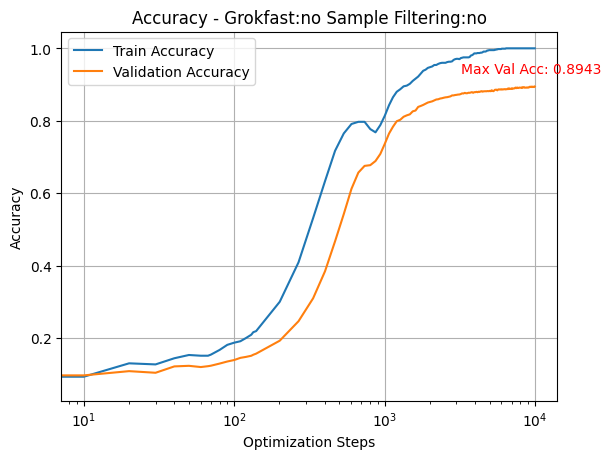

Plots saved successfully.


In [215]:
args.label="filternone_sampling_False_v2"
analyze_results(args.label)

In [49]:
if __name__ == "__main__":
    # Same as used in paper of Grokfast
    parser = ArgumentParser(description="Train a model on MNIST without custom sampling")
    
    parser.add_argument("--label", type=str, default="")
    parser.add_argument("--seed", type=int, default=1)
    
    parser.add_argument("--train_points", type=int, default=1000)
    parser.add_argument("--optimization_steps", type=int, default=10000)
    parser.add_argument("--batch_size", type=int, default=200)
    parser.add_argument("--loss_function", type=str, default="MSE") #MSE or CrossEntropy
    parser.add_argument("--optimizer", type=str, default="AdamW")
    parser.add_argument("--weight_decay", type=float, default=2.0)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--initialization_scale", type=float, default=8.0)
    parser.add_argument("--download_directory", type=str, default=".")
    parser.add_argument("--depth", type=int, default=3)
    parser.add_argument("--width", type=int, default=200)
    parser.add_argument("--activation", type=str, default="ReLU")

    # Grokfast
    parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="none")
    parser.add_argument("--alpha", type=float, default=0.8)
    parser.add_argument("--lamb", type=float, default=0.1)

    # Samples ranking
    parser.add_argument("--ema_alpha_sampl_rank", type=float, default=0.9)

    # Boolean arguements need this due to bad behavior of parser.parse_args
    def boolean_string(s):
        if s not in {"False", "True"}:
            raise ValueError("Not a valid boolean string")
        return s == "True"

    # These are the hyperparameters related to our online sampling filtering algorithm
    parser.add_argument("--appl_sampl_filter", type=boolean_string, default=True)  # If False, perform regular training
    parser.add_argument("--sampling_distr_upd_freq", type=int, default=1)  # How often to update the sampling distribution
    parser.add_argument("--top_k", type=float, default=0.1)  # Fraction of samples to select more frequently
    parser.add_argument("--top_k_sampling_prob", type=float, default=0.9)  # Probability of selecting a sample from the top-k
    parser.add_argument("--high_freq_better", type=boolean_string, default=True)  # If True, samples with higher frequency gradient content are considered better for training

    # -----------------------------------------------------------------
    # Try different hyperparameter values for your grid search here
    # -----------------------------------------------------------------
    args = parser.parse_args(
        [
            "--appl_sampl_filter", "False", # booleans as non strings in order to work
            "--sampling_distr_upd_freq", "1", # the rest as strings for some reason
            "--top_k", "0.1",
            "--top_k_sampling_prob", "0.9",
            "--high_freq_better", "True",
        ]
    )
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    # Create arg.label for the filename of the saved results
    if not args.appl_sampl_filter:
        args.label = f"filter{args.filter}_sampling_{args.appl_sampl_filter}"
    else:
        args.label = f"high_freq_{args.high_freq_better}_top_k_{args.top_k}_top_k_prob_{args.top_k_sampling_prob}_upd_freq_{args.sampling_distr_upd_freq}"

    # Training with time recording

    # Start the timer
    start_time = time.time()

    # Call your training function
    main(args)

    # End the timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to minutes and seconds (optional)
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Training completed in {int(minutes)} minutes and {int(seconds)} seconds.")
    print(f"label:{args.label}")

Number of parameters: 199210


  0%|          | 0/10000 [00:00<?, ?it/s]


Steps needed to reach 0.9 validation accuracy: None
Training completed in 2 minutes and 22 seconds.
label:filternone_sampling_False


Steps needed to reach 0.9 validation accuracy: None


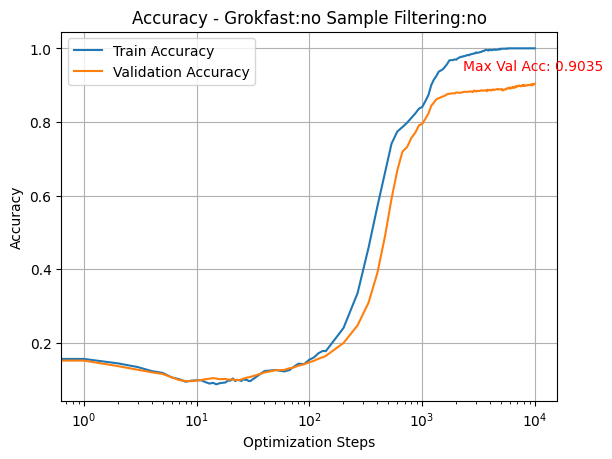

Plots saved successfully.


In [94]:

args.label="filternone_sampling_False"
analyze_results(args.label)


In [87]:
import itertools

parser = ArgumentParser(description="Train a model on MNIST without custom sampling")

parser.add_argument("--label", type=str, default="")
parser.add_argument("--seed", type=int, default=1)

parser.add_argument("--train_points", type=int, default=1000)
parser.add_argument("--optimization_steps", type=int, default=10000)
parser.add_argument("--batch_size", type=int, default=200)
parser.add_argument("--loss_function", type=str, default="MSE") #MSE or CrossEntropy
parser.add_argument("--optimizer", type=str, default="AdamW")
parser.add_argument("--weight_decay", type=float, default=2.0)
parser.add_argument("--lr", type=float, default=1e-3)
parser.add_argument("--initialization_scale", type=float, default=8.0)
parser.add_argument("--download_directory", type=str, default=".")
parser.add_argument("--depth", type=int, default=3)
parser.add_argument("--width", type=int, default=200)
parser.add_argument("--activation", type=str, default="ReLU")

# Grokfast
parser.add_argument("--filter", type=str, choices=["none", "ma", "ema", "fir"], default="ema")
parser.add_argument("--alpha", type=float, default=0.8)
parser.add_argument("--lamb", type=float, default=1)

# Samples ranking
parser.add_argument("--ema_alpha_sampl_rank", type=float, default=0.9)

# Boolean arguements need this due to bad behavior of parser.parse_args
def boolean_string(s):
    if s not in {"False", "True"}:
        raise ValueError("Not a valid boolean string")
    return s == "True"

# These are the hyperparameters related to our online sampling filtering algorithm
parser.add_argument("--appl_sampl_filter", type=boolean_string, default=True)  # If False, perform regular training
parser.add_argument("--sampling_distr_upd_freq", type=int, default=1)  # How often to update the sampling distribution
parser.add_argument("--top_k", type=float, default=0.1)  # Fraction of samples to select more frequently
parser.add_argument("--top_k_sampling_prob", type=float, default=0.9)  # Probability of selecting a sample from the top-k
parser.add_argument("--high_freq_better", type=boolean_string, default=True)  # If True, samples with higher frequency gradient content are considered better for training



_StoreAction(option_strings=['--high_freq_better'], dest='high_freq_better', nargs=None, const=None, default=True, type=<function boolean_string at 0x78bc637508b0>, choices=None, required=False, help=None, metavar=None)

In [131]:
# Define possible values for each parameter
param_grid = {
    "top_k": [0.2],  # Convert to float
    "top_k_sampling_prob": [0.6, 0.8],  # Convert to float
    "sampling_distr_upd_freq": [100],  # Convert to int
    "high_freq_better": [False, True]  # Boolean parameter
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))

# Run main in a loop for each combination
for param_values in param_combinations:
    # Extract parameter values
    top_k = param_values[0]
    top_k_sampling_prob = param_values[1]
    sampling_distr_upd_freq = param_values[2]
    high_freq_better = param_values[3]  # Boolean value
    
    # Ensure boolean values are correctly formatted as strings for argparse
    high_freq_better_str = "True" if high_freq_better else "False"

    # Create args dynamically
    args_list = [
        "--top_k", str(top_k),
        "--top_k_sampling_prob", str(top_k_sampling_prob),
        "--sampling_distr_upd_freq", str(sampling_distr_upd_freq),
        "--high_freq_better", high_freq_better_str,
        "--label", f"{top_k}_{top_k_sampling_prob}_{sampling_distr_upd_freq}_{high_freq_better}"
    ]

    # Debug print statement
    print(f"\nRunning with parameters: {args_list}")

    # Parse the arguments dynamically
    args = parser.parse_args(args_list)

    # Call main() with the updated args
    main(args)


Running with parameters: ['--top_k', '0.2', '--top_k_sampling_prob', '0.6', '--sampling_distr_upd_freq', '100', '--high_freq_better', 'False', '--label', '0.2_0.6_100_False']
Number of parameters: 199210


<ipython-input-79-40a61105ccb4>:104: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.grad` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.grad` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  gradient_fn = grad(compute_loss_vmap)


  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-79-40a61105ccb4>:182: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(gradient_fn, in_dims=(None, None, None, 0, 0))(
<ipython-input-79-40a61105ccb4>:92: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  logits = functional_call(model, {**params, **buffers}, x.unsqueeze(0))  # Single input
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Si


Steps needed to reach 0.9 validation accuracy: None

Running with parameters: ['--top_k', '0.2', '--top_k_sampling_prob', '0.6', '--sampling_distr_upd_freq', '100', '--high_freq_better', 'True', '--label', '0.2_0.6_100_True']
Number of parameters: 199210


<ipython-input-79-40a61105ccb4>:104: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.grad` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.grad` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  gradient_fn = grad(compute_loss_vmap)


  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-79-40a61105ccb4>:182: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(gradient_fn, in_dims=(None, None, None, 0, 0))(
<ipython-input-79-40a61105ccb4>:92: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  logits = functional_call(model, {**params, **buffers}, x.unsqueeze(0))  # Single input
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Si


Steps needed to reach 0.9 validation accuracy: None

Running with parameters: ['--top_k', '0.2', '--top_k_sampling_prob', '0.8', '--sampling_distr_upd_freq', '100', '--high_freq_better', 'False', '--label', '0.2_0.8_100_False']
Number of parameters: 199210


<ipython-input-79-40a61105ccb4>:104: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.grad` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.grad` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  gradient_fn = grad(compute_loss_vmap)


  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-79-40a61105ccb4>:182: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(gradient_fn, in_dims=(None, None, None, 0, 0))(
<ipython-input-79-40a61105ccb4>:92: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  logits = functional_call(model, {**params, **buffers}, x.unsqueeze(0))  # Single input
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Si


Steps needed to reach 0.9 validation accuracy: None

Running with parameters: ['--top_k', '0.2', '--top_k_sampling_prob', '0.8', '--sampling_distr_upd_freq', '100', '--high_freq_better', 'True', '--label', '0.2_0.8_100_True']
Number of parameters: 199210


<ipython-input-79-40a61105ccb4>:104: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.grad` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.grad` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  gradient_fn = grad(compute_loss_vmap)


  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-79-40a61105ccb4>:182: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(gradient_fn, in_dims=(None, None, None, 0, 0))(
<ipython-input-79-40a61105ccb4>:92: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  logits = functional_call(model, {**params, **buffers}, x.unsqueeze(0))  # Single input
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Si


Steps needed to reach 0.9 validation accuracy: None


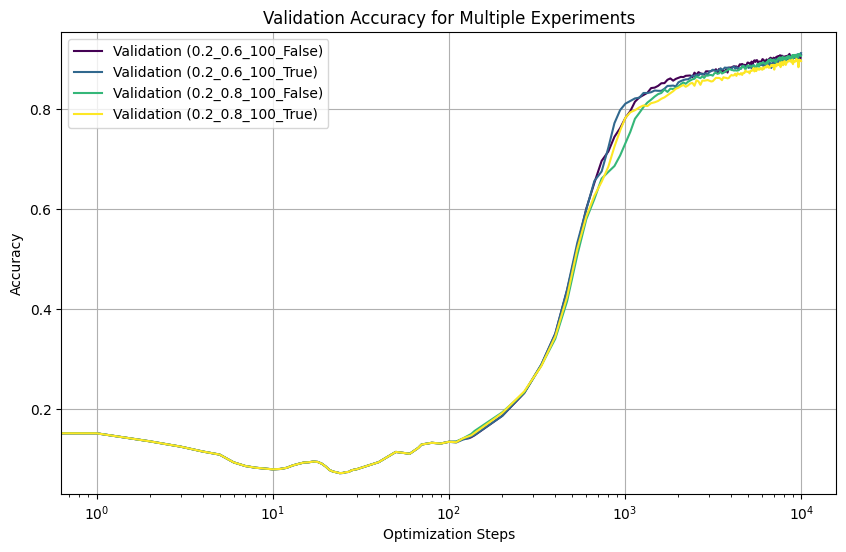

In [147]:
labels = [
    f"{param_values[0]}_{param_values[1]}_{param_values[2]}_{param_values[3]}"
    for param_values in param_combinations
]


# Compare multiple accuracy curves on the same plot
plot_all_experiments_together(labels, show_only_val=True)